In [18]:
# ==============================================================================
# 03_Global_Interpretability.ipynb
# ==============================================================================
# GOAL: Demystify the Black Box using Global Surrogate Models & PDP.
# STRATEGY: 
# 1. Use XGBoost predictions as the "Ground Truth" for simpler models.
# 2. Train a Decision Tree (to get rules) and Linear Regression (to get coefficients).
# 3. Use Partial Dependence Plots (PDP) to show marginal effects.
# ==============================================================================


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb
import warnings
import shap

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import PartialDependenceDisplay

# Settings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
pd.set_option('display.max_columns', None)

print("✅ Libraries Loaded.")

✅ Libraries Loaded.


In [22]:
xgb_model = joblib.load('../models/champion_model.joblib')
calibrator = joblib.load('../models/calibrator.joblib')
model = xgb_model  # Alias for compatibility with older code
feature_names = joblib.load('../models/model_features.joblib')
print(f"✅ Loaded Champion Model: {type(xgb_model).__name__}")
print(f"✅ Loaded calibrator")


X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
print(f"✅ Loaded Data. Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

✅ Loaded Champion Model: XGBClassifier
✅ Loaded calibrator
✅ Loaded Data. Train Shape: (957145, 41), Test Shape: (94893, 41)


In [20]:
import pandas as pd
import re

# 1. 强制清理当前数据框的列名 (防止有空格或特殊字符残留)
def sanitize_feature_names(df):
    new_cols = []
    for col in df.columns:
        # 替换所有非字母、数字和下划线的字符
        new_col = re.sub(r'[\s\[\]<]', '_', col).strip('_')
        new_cols.append(new_col)
    df.columns = new_cols
    return df

X_train = sanitize_feature_names(X_train)
X_test = sanitize_feature_names(X_test)
print("✅ Current feature names sanitized.")

# 2. 识别并创建缺失的特征 (One-Hot 编码常见问题)
# 这一步是为了处理在训练集和测试集中，某些 One-Hot 编码特征未出现的问题。
missing_in_train = set(feature_names) - set(X_train.columns)
missing_in_test = set(feature_names) - set(X_test.columns)

# 强制添加缺失的列，并用 0 填充（通常用于 One-Hot 编码特征）
for col in missing_in_train:
    X_train[col] = 0
for col in missing_in_test:
    X_test[col] = 0

if missing_in_train or missing_in_test:
    print(f"⚠️ Added {len(missing_in_train)} missing columns (set to 0) to X_train.")
    print(f"⚠️ Added {len(missing_in_test)} missing columns (set to 0) to X_test.")
    
# 3. 重新执行特征重排 (Reindexing)
# 现在列名已清理，并且所有需要的列都已存在（即使值是 0）

X_train = X_train[feature_names]
X_test = X_test[feature_names]
print("✅ Features successfully realigned to match model's expected order and names.")

# 4. 最终检查
if X_train.shape[1] == len(feature_names):
    print(f"✨ Final check successful. Feature count: {X_train.shape[1]}")
else:
    print("❌ Final feature count mismatch! Check dropped columns.")

✅ Current feature names sanitized.
⚠️ Added 1 missing columns (set to 0) to X_train.
⚠️ Added 1 missing columns (set to 0) to X_test.
✅ Features successfully realigned to match model's expected order and names.
✨ Final check successful. Feature count: 41


🤖 Generating XGBoost predictions (The 'Soft' Target)...


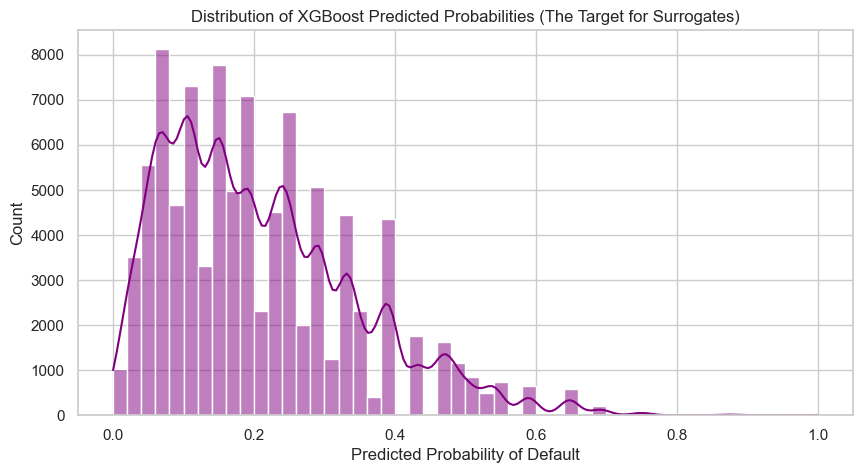

In [23]:
# ==========================================
# 2. Generate "Black Box" Predictions
# ==========================================
# The core idea: We treat the XGBoost PREDICTIONS as our new TARGET.
# We are modeling the model, not the ground truth.

print("🤖 Generating XGBoost predictions (The 'Soft' Target)...")

# Predict Probabilities (Continuous 0-1)
y_pred_xgb_train = calibrator.predict_proba(X_train)[:, 1]
y_pred_xgb_test = calibrator.predict_proba(X_test)[:, 1]

# Visualization: What does the XGBoost thinking look like?
plt.figure(figsize=(10, 5))
sns.histplot(y_pred_xgb_test, bins=50, kde=True, color='purple')
plt.title("Distribution of XGBoost Predicted Probabilities (The Target for Surrogates)")
plt.xlabel("Predicted Probability of Default")
plt.show()

✅ Decision Tree Surrogate R²: 0.7161
   (Interpretation: The simple tree explains 71.6% of the XGBoost logic)


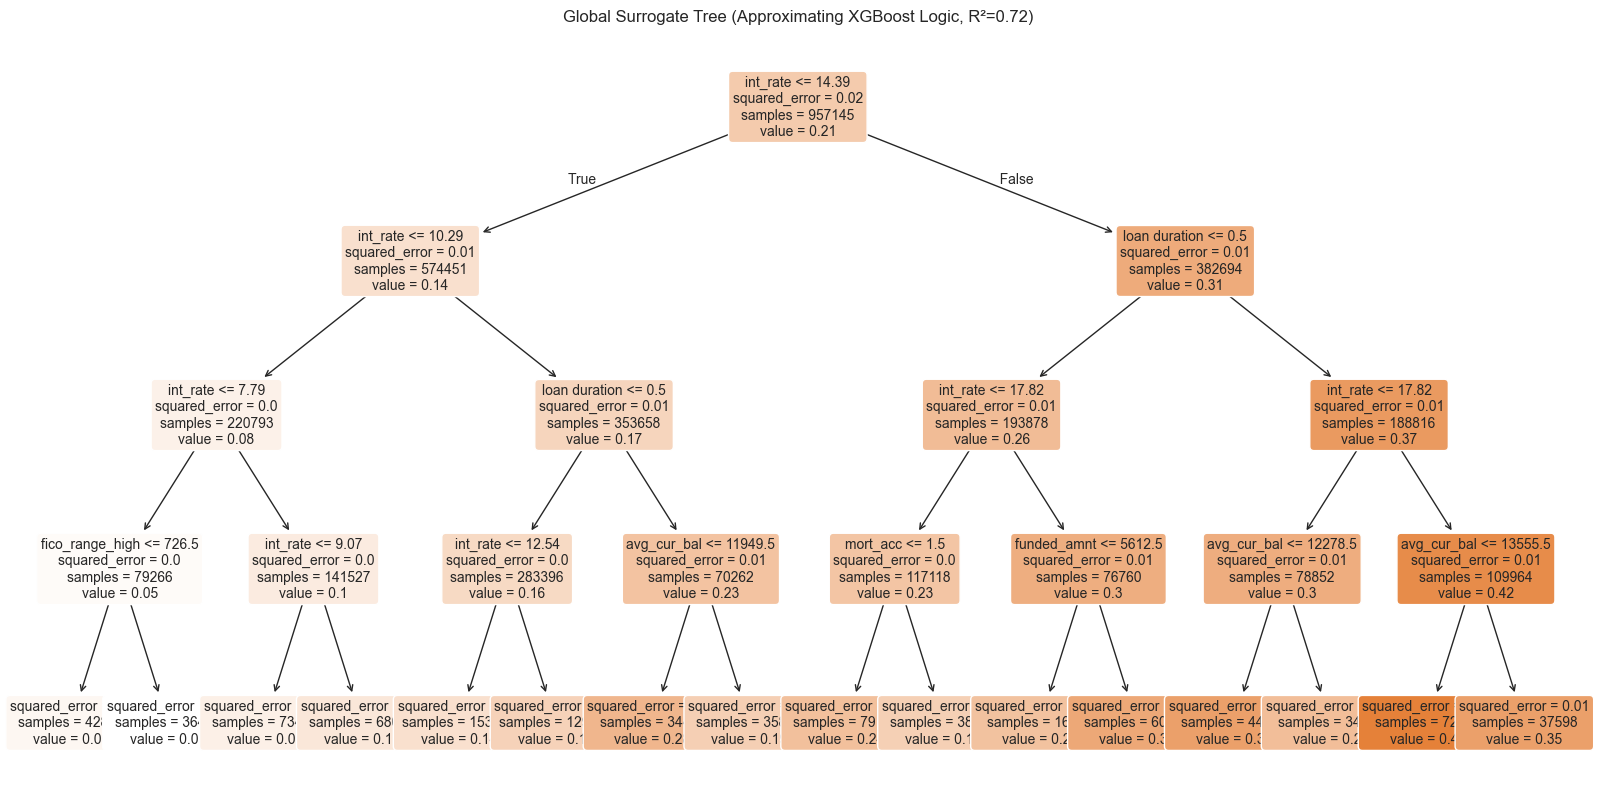


--- 🎯 Surrogate DT Top 15 Feature Importance (Gini Reduction) ---
| Feature       |   Importance |
|:--------------|-------------:|
| int_rate      |       0.8019 |
| loan duration |       0.1330 |
| avg_cur_bal   |       0.0500 |
| funded_amnt   |       0.0079 |
| mort_acc      |       0.0061 |


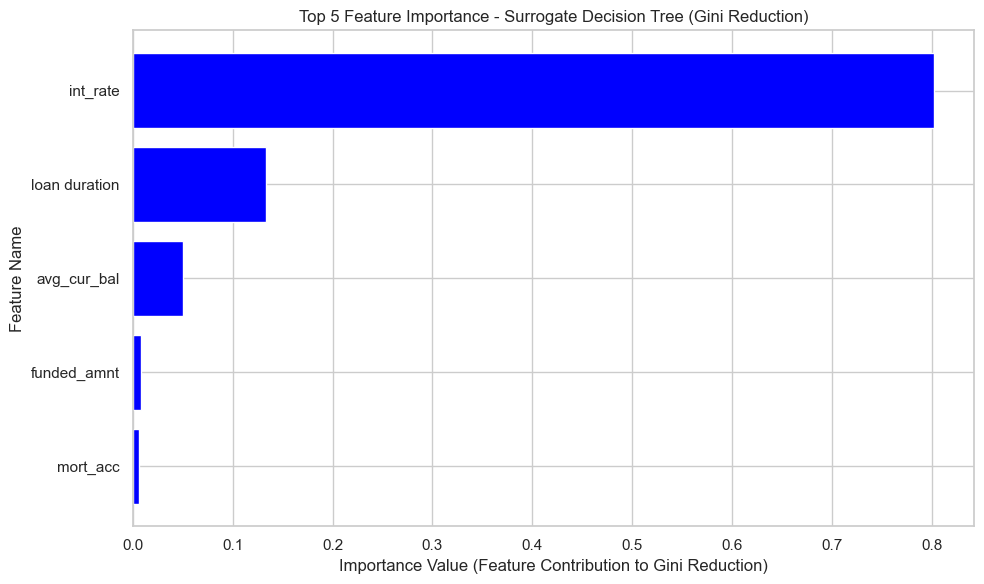

In [29]:
# Surrogate 1: Decision Tree (Rule Extraction)

# Max depth = 4 ensures the tree remains readable for humans
dt_surrogate = DecisionTreeRegressor(max_depth=4, random_state=42)
dt_surrogate.fit(X_train, y_pred_xgb_train)

# Evaluation: How well does the Tree mimic XGBoost?
r2_dt = r2_score(y_pred_xgb_test, dt_surrogate.predict(X_test))
print(f"✅ Decision Tree Surrogate R²: {r2_dt:.4f}")
print("   (Interpretation: The simple tree explains {:.1f}% of the XGBoost logic)".format(r2_dt*100))

# Visualization of the Tree Structure
plt.figure(figsize=(20, 10))
plot_tree(dt_surrogate, 
          feature_names=feature_names, 
          filled=True, 
          rounded=True, 
          fontsize=10,
          precision=2)
plt.title(f"Global Surrogate Tree (Approximating XGBoost Logic, R²={r2_dt:.2f})")
plt.show() # 

importances = dt_surrogate.feature_importances_
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top_5_dt = feature_imp_df.head(5).copy() # 

print("\n--- 🎯 Surrogate DT Top 15 Feature Importance (Gini Reduction) ---")
print(top_5_dt.to_markdown(index=False, floatfmt=".4f"))

# plot
features = top_5_dt['Feature']
importance_values = top_5_dt['Importance']

plt.figure(figsize=(10, 6))
plt.barh(features.iloc[::-1], importance_values.iloc[::-1], color='blue')
plt.title('Top 5 Feature Importance - Surrogate Decision Tree (Gini Reduction)')
plt.xlabel('Importance Value (Feature Contribution to Gini Reduction)')
plt.ylabel('Feature Name')
plt.tight_layout()

plt.show() # 

📈 Training Surrogate Linear Regression...
✅ Linear Regression Surrogate R²: 0.8331


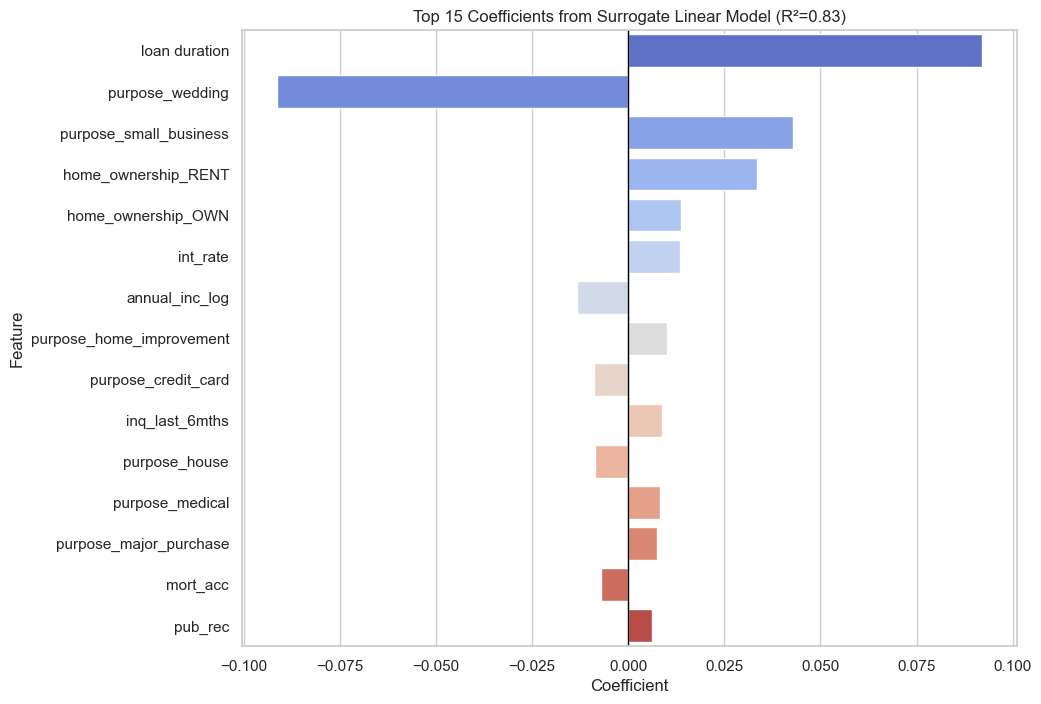

In [26]:
# ==========================================
# 4. Surrogate 2: Linear Regression (Directionality)
# ==========================================
# WHY? To get coefficients that tell us "Average Direction and Magnitude".

print("📈 Training Surrogate Linear Regression...")

lr_surrogate = LinearRegression()
lr_surrogate.fit(X_train, y_pred_xgb_train)

# Evaluation
r2_lr = r2_score(y_pred_xgb_test, lr_surrogate.predict(X_test))
print(f"✅ Linear Regression Surrogate R²: {r2_lr:.4f}")

# Extract Coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_surrogate.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')
plt.title(f"Top 15 Coefficients from Surrogate Linear Model (R²={r2_lr:.2f})")
plt.axvline(0, color='black', linewidth=1)
plt.show()



🔍 Generating Partial Dependence Plots (PDP)...


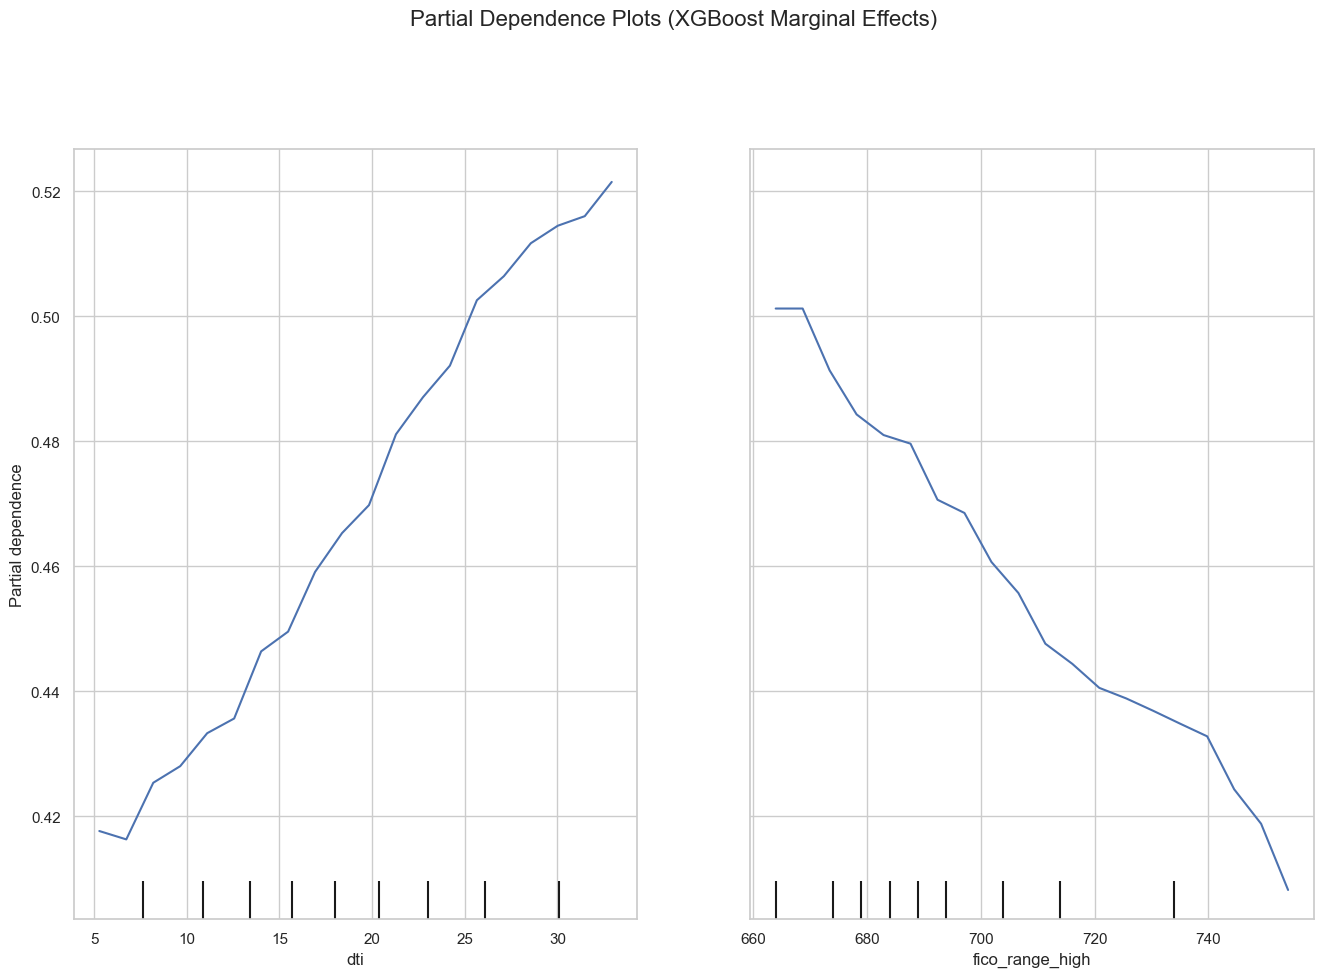

In [27]:
# ==========================================
# 5. Partial Dependence Plots (PDP)
# ==========================================
# WHY? To show the marginal effect of 1 or 2 features on the predicted outcome,
# marginalizing over the values of all other features.

print("🔍 Generating Partial Dependence Plots (PDP)...")

# Select top features to analyze (based on our prior knowledge)
features_to_plot = ['sub_grade', 'dti', 'fico_range_high', 'loan_duration']
# Ensure they exist in columns
features_to_plot = [f for f in features_to_plot if f in X_train.columns]

# We use the raw XGBoost model here, not the surrogate
fig, ax = plt.subplots(figsize=(16, 10))
display = PartialDependenceDisplay.from_estimator(
    estimator=xgb_model,
    X=X_train, # Use a subset if slow: X_train.sample(1000)
    features=features_to_plot,
    kind="average",
    n_jobs=-1,
    grid_resolution=20,
    ax=ax
)
plt.suptitle("Partial Dependence Plots (XGBoost Marginal Effects)", fontsize=16, y=1.02)
plt.show()

# INTERPRETATION:
# 1. Look for Monotonicity: Does Risk go up as Sub_Grade goes up? (Should be YES)
# 2. Look for Non-linearity: Does FICO score flatten out after 750? (Diminishing returns)